In [2]:
import numpy as np
import matplotlib.pyplot as plt
from axel_planner.biped_wheeled_leg import BipedWheeledLeg
from axel_planner.one_leg_reneder import OneLegRenderer
import time
import mujoco
import mujoco.viewer
from copy import deepcopy


In [3]:
leg_model = BipedWheeledLeg()
x_targets = np.linspace(leg_model.x_zero, -0.05, 20)
z_targets = np.linspace(leg_model.y_zero, -0.5, 20)

In [4]:
def quintic_func(q0, qf, T, qd0=0, qdf=0):
    """
    Quintic scalar polynomial as a function

    :param q0: initial value
    :type q0: float
    :param qf: final value
    :type qf: float
    :param T: trajectory time
    :type T: float
    :param qd0: initial velocity, defaults to 0
    :type q0: float, optional
    :param qdf: final velocity, defaults to 0
    :type q0: float, optional
    :return: polynomial function :math:`f: t \mapsto (q(t), \dot{q}(t), \ddot{q}(t))`
    :rtype: callable

    Returns a function which computes the specific quintic polynomial, and its
    derivatives, as described by the parameters.

    Example:

    .. runblock:: pycon

        >>> from roboticstoolbox import quintic_func
        >>> f = quintic_func(1, 2, 5)
        >>> f(0)
        >>> f(5)
        >>> f(2.5)

    :seealso: :func:`quintic` :func:`trapezoidal_func`
    """

    # solve for the polynomial coefficients using least squares
    # fmt: off
    X = [
        [ 0.0,          0.0,         0.0,        0.0,     0.0,  1.0],
        [ T**5,         T**4,        T**3,       T**2,    T,    1.0],
        [ 0.0,          0.0,         0.0,        0.0,     1.0,  0.0],
        [ 5.0 * T**4,   4.0 * T**3,  3.0 * T**2, 2.0 * T, 1.0,  0.0],
        [ 0.0,          0.0,         0.0,        2.0,     0.0,  0.0],
        [20.0 * T**3,  12.0 * T**2,  6.0 * T,    2.0,     0.0,  0.0],
    ]
    # fmt: on
    coeffs, resid, rank, s = np.linalg.lstsq(
        X, np.r_[q0, qf, qd0, qdf, 0, 0], rcond=None
    )

    # coefficients of derivatives
    coeffs_d = coeffs[0:5] * np.arange(5, 0, -1)
    coeffs_dd = coeffs_d[0:4] * np.arange(4, 0, -1)

    return lambda x: (
        np.polyval(coeffs, x),
        np.polyval(coeffs_d, x),
        np.polyval(coeffs_dd, x),
    )

In [5]:
traj_velocity = 1.0  # m/s
traj_point_per_meter = 100

start_point = (leg_model.x_zero, leg_model.y_zero)
end_point = (-0.05, -0.5)
traj_length = np.linalg.norm(np.array(end_point) - np.array(start_point))

time_traj = traj_length / traj_velocity
num_points = int(traj_length * traj_point_per_meter)
traj_dt = time_traj / num_points

x_fun_traj = quintic_func(leg_model.x_zero, -0.05, time_traj)
y_fun_traj = quintic_func(leg_model.y_zero, -0.5, time_traj)

time_array = np.linspace(0, time_traj, num_points)
x_traj = np.array([x_fun_traj(t)[0] for t in time_array])
y_traj = np.array([y_fun_traj(t)[0] for t in time_array])

q_values = np.array([leg_model.ik_solve(x, y) for x, y in zip(x_traj, y_traj)])

print("time_traj:", time_traj)
print("num_points:", num_points)
print("traj_dt:", traj_dt)

time_traj: 0.37078049560884824
num_points: 37
traj_dt: 0.010021094475914817


In [6]:
# leg_model = BipedWheeledLeg()
# renderer = OneLegRenderer("biped_wheeled_leg/biped_wheeled_leg.xml")
# renderer.init_render()
# for i in range(q_values.shape[0]):
#     hip_motor = q_values[i, 0]
#     knee_motor = q_values[i, 1]
#     renderer.render(hip_motor, knee_motor, x_traj[i % 100], y_traj[i % 100])
#     time.sleep(0.05)
# renderer.viewer.close()

In [24]:


leg_model = BipedWheeledLeg()
renderer = OneLegRenderer("biped_wheeled_leg/biped_wheeled_leg.xml")


model = mujoco.MjModel.from_xml_path("biped_wheeled_leg/biped_wheeled_leg.xml")
data = mujoco.MjData(model)
squat_start0 = np.array(
    [
        -1.42061623e00,
        4.44764361e-01,
        1.93904131e-01,
        4.45567941e-01,
        -4.45608133e-01,
        -6.59323543e-01,
        3.16772344e-02,
        0.00000000e00,
        0.00000000e00,
        -5.89188600e01,
        1.00000000e00,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
    ]
)
data.qpos = squat_start0

mujoco.mj_kinematics(model, data)


ee_id = data.body("ankle_wheel_link").id
x_start = data.xpos[ee_id][0]
z_start = data.xpos[ee_id][2]


traj_velocity = 0.5  # m/s
traj_point_per_meter = 100

start_point = (x_start, z_start)
end_point = (0, -0.6)
traj_length = np.linalg.norm(np.array(end_point) - np.array(start_point))

time_traj = traj_length / traj_velocity
num_points = int(traj_length * traj_point_per_meter)
traj_dt = time_traj / num_points

x_fun_traj = quintic_func(x_start, end_point[0], time_traj)
y_fun_traj = quintic_func(z_start, end_point[1], time_traj)

time_array = np.linspace(0, time_traj, num_points)
x_traj = np.array([x_fun_traj(t)[0] for t in time_array])
y_traj = np.array([y_fun_traj(t)[0] for t in time_array])

q_values = np.array([leg_model.ik_solve(x, y) for x, y in zip(x_traj, y_traj)])

print("time_traj:", time_traj)
print("num_points:", num_points)
print("traj_dt:", traj_dt)


renderer.init_render()
traj_it = 0
tau_array = []
q_act_array = []
q_des_array = []
while data.time < 1.0:
    traj_it = min(int(data.time / traj_dt), num_points - 1)
    hip_mot_des = q_values[traj_it, 0]
    knee_mot_des = q_values[traj_it, 1]
    data.ctrl = [hip_mot_des, knee_mot_des]
    knee_mot = data.joint("knee_crank_joint").qpos
    hip_mot = data.joint("hip_pitch_joint").qpos
    
    data.xfrc_applied[ee_id][:3] = [0, 0, 100]
 
    mujoco.mj_step(model, data)
    tau_array.append(deepcopy(data.actuator_force))
    q_act_array.append(deepcopy([knee_mot, hip_mot]))
    q_des_array.append(deepcopy([knee_mot_des, hip_mot_des]))
    renderer.render(hip_mot, knee_mot, x_traj[traj_it], y_traj[traj_it])
    


renderer.viewer.close()
q_act_array = np.array(q_act_array)
q_des_array = np.array(q_des_array)
squat_start = data.qpos

time_traj: 0.520578221773303
num_points: 26
traj_dt: 0.020022239298973194


In [8]:
renderer.viewer.close()

In [9]:


forward_xy = leg_model.forward_kinematics(q_des_array[-1, 0], q_des_array[-1, 1])  
forward_xy_mj = renderer.forward_mujoco(q_des_array[-1, 0], q_des_array[-1, 1])
print(f"Desired q {q_des_array[-1, 0], q_des_array[-1, 1]}")
#print(f"Forward {forward_xy}")
print(leg_model.ik_solve(forward_xy[0], forward_xy[1]))
leg_model.ik_solve(forward_xy[0], forward_xy[1])[0] - q_des_array[-1, 0]
 

Desired q (np.float64(-0.9191241863532974), np.float64(-0.7077610720453748))
(np.float64(-0.9191241863532974), np.float64(-0.7077610720453745))


np.float64(0.0)

In [10]:
def get_trajectory(start_point_xy, end_point_xy, traj_velocity=0.5, traj_point_per_meter=100):
    traj_length = np.linalg.norm(np.array(end_point_xy) - np.array(start_point_xy))

    time_traj = traj_length / traj_velocity
    num_points = int(traj_length * traj_point_per_meter)
    traj_dt = time_traj / num_points

    x_fun_traj = quintic_func(start_point_xy[0], end_point_xy[0], time_traj)
    y_fun_traj = quintic_func(start_point_xy[1], end_point_xy[1], time_traj)

    time_array = np.linspace(0, time_traj, num_points)
    x_traj = np.array([x_fun_traj(t)[0] for t in time_array])
    y_traj = np.array([y_fun_traj(t)[0] for t in time_array])

    return x_traj, y_traj, time_traj, num_points, traj_dt
 

Text(0.5, 1.0, 'Actuator Forces over Time')

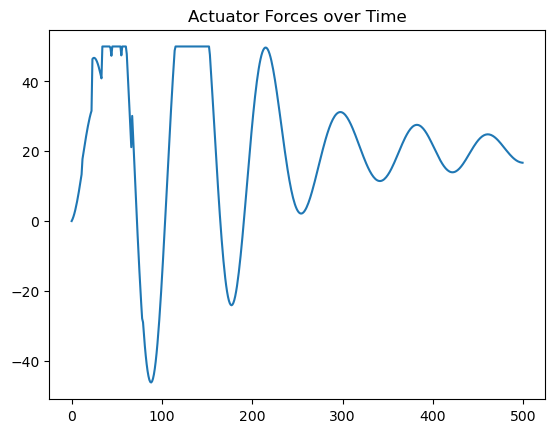

In [11]:
plt.plot(np.array(tau_array)[:, 0], label="knee actuator")
plt.title("Actuator Forces over Time")

Text(0.5, 1.0, 'Actuator Forces over Time')

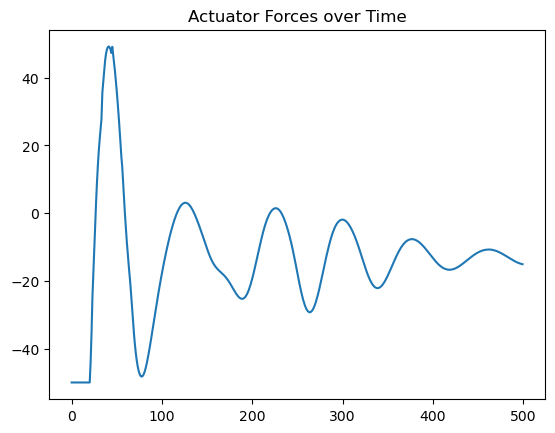

In [12]:
plt.plot(np.array(tau_array)[:, 1], label="hip actuator")
plt.title("Actuator Forces over Time")

Text(0.5, 1.0, 'Actual Joint Positions over Time')

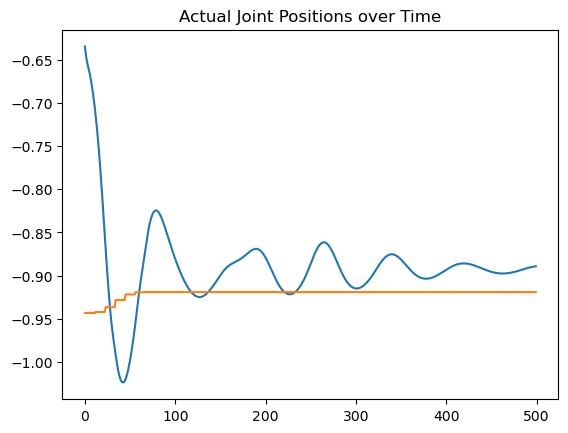

In [13]:
plt.plot(q_act_array[:, 0], label="knee actual")
plt.plot(q_des_array[:, 0], label="knee desired")
plt.title("Actual vs Desired Joint Positions over Time - Knee")
plt.title("Actual Joint Positions over Time")

Text(0.5, 1.0, 'Actual Joint Positions over Time')

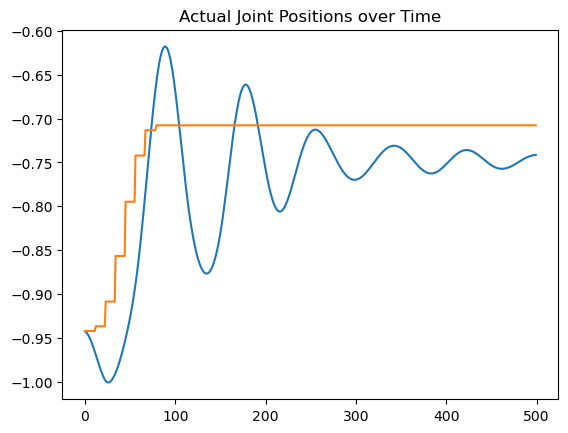

In [14]:
plt.plot(q_act_array[:, 1], label="hip actual")
plt.plot(q_des_array[:, 1], label="hip desired")
plt.title("Actual vs Desired Joint Positions over Time - Hip")
plt.title("Actual Joint Positions over Time")

In [1]:
import numpy as np
D = (6.5*0.0254)
R = D/2

rotation_per_sec = 300/(60)
v_mc = 2*np.pi*R*rotation_per_sec
v_kph = v_mc *3.6
v_kph

9.336185047938148